In [37]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
clean_df = pd.read_sql_query('select * from "merged_final"',con=engine)

In [4]:
clean_df.shape

(3179300, 17)

In [5]:
sample = clean_df.sample(n=2000000)

In [6]:
sample = sample[sample['vote'] <= 1]

In [7]:
sample.head()

,index,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,sponsor_party
2515080,2515284,1,2012-02-10,630,0,2011-12 ESHB 2361,81818.0,2011-12,ESHB 2361,http://app.leg.wa.gov/documents/billdocs/2011-...,0,39,0,False,False,False,0
3073022,3073226,1,2018-02-12,26178,0,2017-18 ESHB 2381,102590.0,2017-18,ESHB 2381,http://app.leg.wa.gov/documents/billdocs/2017-...,0,43,0,True,False,False,0
1979502,1484989,1,2004-02-13,1587,0,2003-04 HB 1667,46878.0,2003-04,HB 1667,http://app.leg.wa.gov/documents/billdocs/2003-...,0,14,1,False,True,False,0
1002645,1002830,1,1998-02-09,618,1,1997-98 SB 6451,29615.0,1997-98,SB 6451,http://app.leg.wa.gov/documents/billdocs/1997-...,1,3,0,False,True,False,1
2706654,2706858,1,2014-02-13,630,0,2013-14 HB 2456,88909.0,2013-14,HB 2456,http://app.leg.wa.gov/documents/billdocs/2013-...,0,44,0,False,False,False,0


In [89]:
len(sample['vote'])

1943788

In [90]:
sample['vote'].sum()

1751152

### Thing to consider
bill length  
NLP  
google search data
year
topics

In [91]:
1751152/1942788

0.9013603131170256

### Baseline Model

In [55]:
X = sample[['sponsor_party', 'party']]
y = sample['vote']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=709)

In [57]:
baseline_model = LogisticRegression()

In [58]:
baseline_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
y_pred = baseline_model.predict_proba(X_test)

In [60]:
log_loss(y_test, y_pred)

0.31977793510725233

### Second Model

In [74]:
X_2 = sample[['sponsor_party', 'party', 'voting_agency', 'sponsor_agency', 
              'district', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 'voter_id']]
y_2 = sample['vote']

In [75]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.30, random_state=709)

In [76]:
second_model = LogisticRegression()

In [77]:
second_model.fit(X_train_2, y_train_2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
y_pred_2 = second_model.predict_proba(X_test_2)

In [79]:
log_loss(y_test_2, y_pred_2)

0.3146348136734083

In [80]:
len(y_test_2), len(y_pred_2)

(583137, 583137)

In [81]:
y_test_2.shape, y_pred_2.shape

((583137,), (583137, 2))

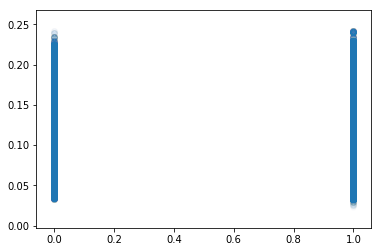

In [82]:
fig, ax = plt.subplots()
ax.scatter(y_test_2, y_pred_2[:,0], alpha=0.01)

In [83]:
len(y_pred_2)

583137

In [84]:
sum(y_pred_2)

array([ 59292.49536593, 523844.50463414])

### Third Model

In [85]:
r_model = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=2, random_state=709)

In [86]:
r_model.fit(X_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=709, verbose=0, warm_start=False)

In [87]:
y_pred_r = r_model.predict_proba(X_test_2)

In [88]:
log_loss(y_test_2, y_pred_r)

0.3060378183692334

In [70]:
sum(y_test)

525255

In [71]:
sum(y_pred)

583137